In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
dim = 1
seed=67

dt = 0.05
t_data = [0,tf]

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

# Locally adaptive time-stepping for two cells after proliferation

In [5]:
cell_list = [cl.Cell(0, [0], proliferating=False), cl.Cell(1, [0.3], proliferating=False)]

In [6]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


## No Jacobian - accuracy bound only

Initial step cubic 0.011066761896076747
Stability bound estimate cubic 0.7048064973592634
Initial step pw. quad. 0.018554836749012055
Stability bound estimate pw. quad. 0.666915068843293
Initial step GLS 0.02863139501885467
Stability bound estimate GLS 0.5681495336428583


Text(0, 0.5, '$\\Delta t$ in hours')

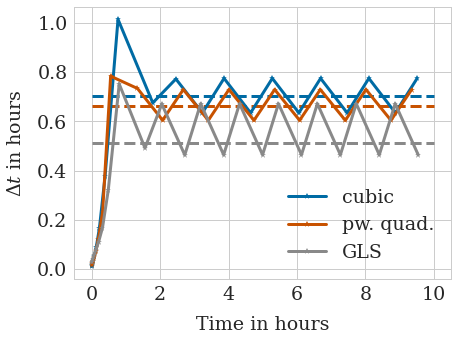

In [19]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

ts = {}

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('step_sizes_local'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('levels'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('n_eq_per_level'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts[force], history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.05,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True, "local_adaptivity": True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[force][:-1], dts,'-*', label=force, color=colors[force])




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
#plt.ylim([-0.1, 1.2])
#plt.savefig('adaptivity_pairwise_relaxation_eps0_05.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_01.png', bbox_inches='tight')

Text(0, 0.5, 'Number of equations per level')

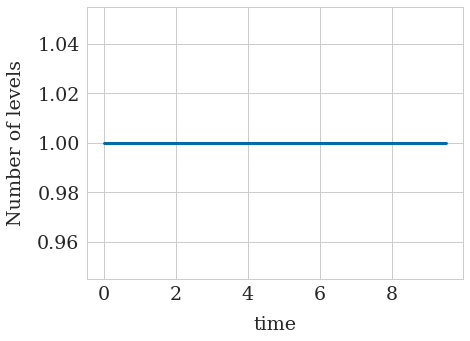

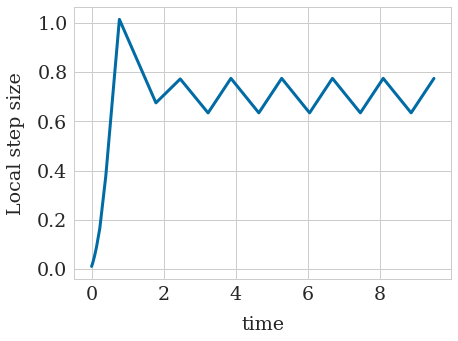

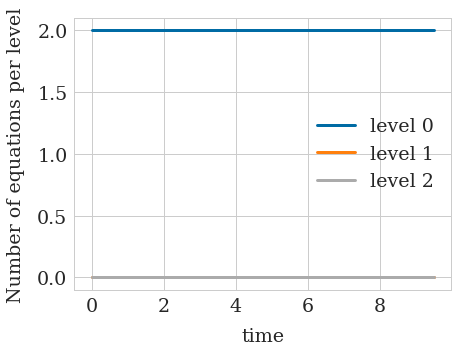

In [22]:
force = 'cubic'
plt.figure()
lev  = np.loadtxt('levels'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], lev)
plt.xlabel('time')
plt.ylabel('Number of levels')

plt.figure()
dt_locals  = np.loadtxt('step_sizes_local'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], dt_locals)
plt.xlabel('time')
plt.ylabel('Local step size')

plt.figure()
n_eq_per_level = np.loadtxt('n_eq_per_level'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], n_eq_per_level[0,:], label='level 0')
plt.plot(ts[force][:-1], n_eq_per_level[1,:], label='level 1')
plt.plot(ts[force][:-1], n_eq_per_level[2,:], label='level 2')
plt.legend()
plt.xlabel('time')
plt.ylabel('Number of equations per level')

Text(0, 0.5, 'Number of equations per level')

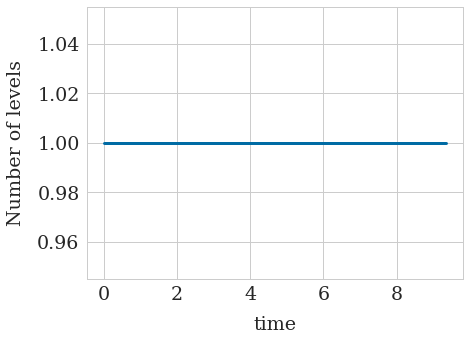

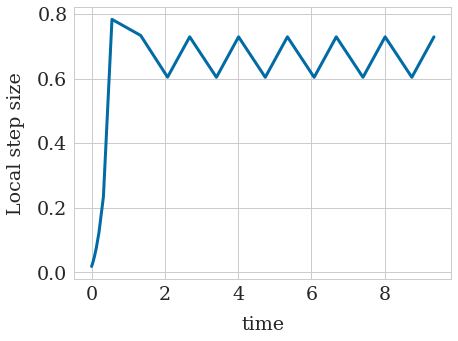

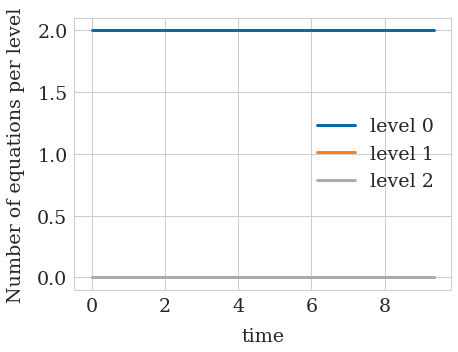

In [23]:
force = 'pw. quad.'
plt.figure()
lev  = np.loadtxt('levels'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], lev)
plt.xlabel('time')
plt.ylabel('Number of levels')

plt.figure()
dt_locals  = np.loadtxt('step_sizes_local'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], dt_locals)
plt.xlabel('time')
plt.ylabel('Local step size')

plt.figure()
n_eq_per_level = np.loadtxt('n_eq_per_level'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], n_eq_per_level[0,:], label='level 0')
plt.plot(ts[force][:-1], n_eq_per_level[1,:], label='level 1')
plt.plot(ts[force][:-1], n_eq_per_level[2,:], label='level 2')
plt.legend()
plt.xlabel('time')
plt.ylabel('Number of equations per level')

Text(0, 0.5, 'Number of equations per level')

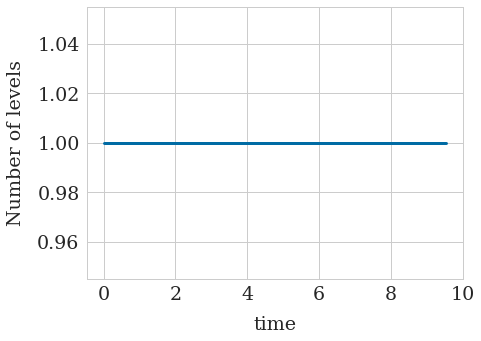

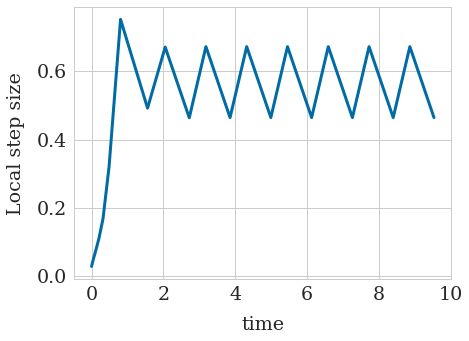

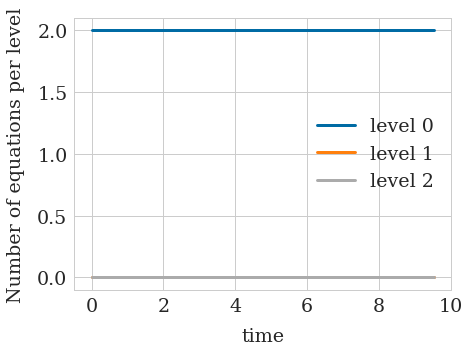

In [24]:
force = 'GLS'
plt.figure()
lev  = np.loadtxt('levels'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], lev)
plt.xlabel('time')
plt.ylabel('Number of levels')

plt.figure()
dt_locals  = np.loadtxt('step_sizes_local'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], dt_locals)
plt.xlabel('time')
plt.ylabel('Local step size')

plt.figure()
n_eq_per_level = np.loadtxt('n_eq_per_level'+filename_ending[force]+'.txt')
plt.plot(ts[force][:-1], n_eq_per_level[0,:], label='level 0')
plt.plot(ts[force][:-1], n_eq_per_level[1,:], label='level 1')
plt.plot(ts[force][:-1], n_eq_per_level[2,:], label='level 2')
plt.legend()
plt.xlabel('time')
plt.ylabel('Number of equations per level')

Initial step cubic 0.004949206378086414
Stability bound estimate cubic 0.7018771254037288
Initial step pw. quad. 0.00829797525644043
Stability bound estimate pw. quad. 0.6640864540453746
Initial step GLS 0.012804349110561582
Stability bound estimate GLS 0.5217906815013682


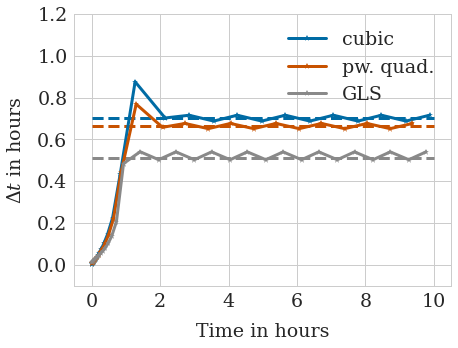

In [9]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True, "local_adaptivity": True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_pairwise_relaxation_eps0_01.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_01.png', bbox_inches='tight')

Nothing to delete.
Initial step cubic 0.0015650764764985523
Stability bound estimate cubic 0.7017556136981115
Nothing to delete.
Initial step pw. quad. 0.0026240501778071555
Stability bound estimate pw. quad. 0.6639695160750241
Nothing to delete.
Initial step GLS 0.004049090714532575
Stability bound estimate GLS 0.5136753923095251


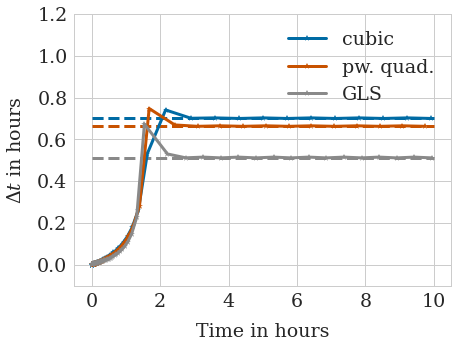

In [10]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True, "local_adaptivity": True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_pairwise_relaxation_eps0_001.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_001.png', bbox_inches='tight')


In [10]:
# Accuracy bound for initial step:
eps = 0.001
r0 = 0.3

gp_cubic = cubic_prime(r0, params_cubic['mu'], s, rA)
ab_cubic = np.sqrt(eps/(gp_cubic*np.abs(ff.Cubic()(r0, **params_cubic))))

gp_pwq = pwq_prime(r0, params_poly['muA'], rA, muR, params_poly['rR'], s)
ab_pwq = np.sqrt(eps/(gp_pwq*np.abs(ff.PiecewisePolynomial()(r0, **params_poly))))

gp_gls = gls_prime(r0, params_gls['mu'],s)
ab_gls = np.sqrt(eps/(gp_gls*np.abs(params_gls['mu']*np.log(1+r0-s))))

print('Analytical accuracy bounds for the first step, eps= '+ str(eps))
print('Cubic '+str(ab_cubic))
print('PWQ '+ str(ab_pwq))
print('GLS ' + str(ab_gls))

Analytical accuracy bounds for the first step, eps= 0.001
Cubic 0.003128366173325387
PWQ 0.005246890209381213
GLS 0.008095015365876104


## Using the Jacobian to obtain the stability bound

In [11]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


In [12]:
dts = np.loadtxt('step_sizes_pwq.txt')

In [13]:
dts

array([0.0052481 , 0.00566116, 0.00611892, 0.00662762, 0.00719461,
       0.0078285 , 0.00853953, 0.00933987, 0.01024412, 0.01126982,
       0.01243828, 0.0137755 , 0.01531346, 0.01709188, 0.0191605 ,
       0.02158234, 0.0244382 , 0.02783319, 0.03190641, 0.03684572,
       0.04291139, 0.0504758 , 0.06009429, 0.07264173, 0.08960251,
       0.11376975, 0.15126343, 0.21930205, 0.40083326, 0.87128102,
       0.67892198, 0.66913671, 0.6589784 , 0.66899713, 0.65897733,
       0.66899714, 0.65897733, 0.66899714, 0.65897733, 0.66899714,
       0.65897733, 0.31043208])

Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.


(-0.1, 1.2)

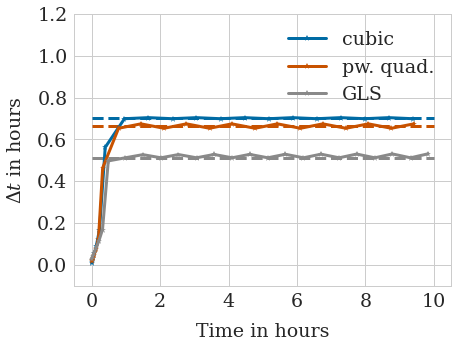

In [14]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

#force_names = ['cubic', 'pw. quad.']
for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvalues'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvectors'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.05, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], "local_adaptivity": True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    #print('Initial step '+force + ' ' +str(dts[0]))
    #print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts[:],'-*', label=force, color=colors[force])
    #plt.plot(ts[:-1], dts[:, 1],'-*', label=force+', acc', color=colors[force], linestyle=':')




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])


Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.


(-0.1, 1.2)

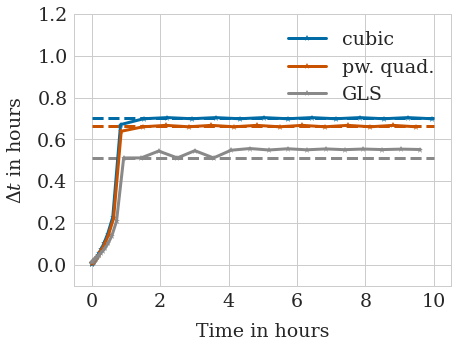

In [13]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

#force_names = ['cubic', 'pw. quad.']
for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvalues'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvectors'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], "local_adaptivity": True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    #print('Initial step '+force + ' ' +str(dts[0]))
    #print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts[:],'-*', label=force, color=colors[force])
    #plt.plot(ts[:-1], dts[:, 1],'-*', label=force+', acc', color=colors[force], linestyle=':')




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])


In [16]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.
Nothing to delete.


(-0.1, 1.2)

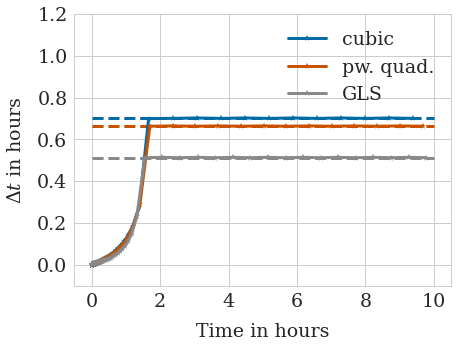

In [15]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

#force_names = ['cubic', 'pw. quad.']
for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvalues'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvectors'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], "local_adaptivity": True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    #print('Initial step '+force + ' ' +str(dts[0]))
    #print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts[:],'-*', label=force, color=colors[force])
    #plt.plot(ts[:-1], dts[:, 1],'-*', label=force+', acc', color=colors[force], linestyle=':')




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
